In [1]:
import pandas as pd
import pathlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import normalize
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
rawdata=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('data','Tn_library_DB_qval_log2FC_imputed.csv'))
mcbwser=pd.read_excel(pathlib.Path.cwd().parents[0].joinpath('data','annotations','Mycobacterium_tuberculosis_H37Rv_txt_v3.xlsx'))

In [3]:
mcbwser.head()

,Refseq_ID,Feature,Rv_ID,Name,Function,Product,Comments,Functional_Category
0,NC_000962.3,CDS,Rv3728,Rv3728,"Unknown, but seems involved in efflux system (...",Probable conserved two-domain membrane protein,"Rv3728, (MTV025.076), len: 1065 aa. Probable c...",cell wall and cell processes
1,NC_000962.3,CDS,Rv3729,Rv3729,Function unknown; probably involved in cellula...,Possible transferase,"Rv3729, (MTV025.077), len: 776 aa. Conserved h...",intermediary metabolism and respiration
2,NC_000962.3,CDS,Rv3730c,Rv3730c,Function unknown,Conserved hypothetical protein,"Rv3730c, (MTV025.078c), len: 346 aa. Conserved...",conserved hypotheticals
3,NC_000962.3,CDS,Rv3760,Rv3760,Unknown,Possible conserved membrane protein,"Rv3760, (MTV025.108), len: 100 aa. Possible co...",cell wall and cell processes
4,NC_000962.3,CDS,Rv3732,Rv3732,Function unknown,Conserved protein,"Rv3732, (MTV025.080), len: 352 aa. Conserved p...",conserved hypotheticals


In [4]:
lfc_cols=list(rawdata.filter(regex='log2FC').columns)
qval_cols=list(rawdata.filter(regex='q_val').columns)

In [5]:
rawdata.shape

(3990, 114)

In [6]:
lfc=rawdata[['Rv_ID']+lfc_cols]
lfc.head()

,Rv_ID,2003A_Sassetti_log2FC,2003B_Sassetti_log2FC,2005_Rengarajan_log2FC,2006_Joshi_GI_1_log2FC,2006_Joshi_GI_2_log2FC,2011_Griffin_2_log2FC,2013_Zhang_1_log2FC,2013_Zhang_2_log2FC,2013_Zhang_3A_log2FC,...,ponA1_log2FC,Rv1565c_log2FC,Rv3684_log2FC,Rv0954_log2FC,Rv3811_log2FC,Rv1096_log2FC,Rv2680_log2FC,Rv1432_log2FC,Rv3594_log2FC,Rv3005c_log2FC
0,Rv0001,-3.378401,0.0,0,0,0,0.0,0.000000,0.0,0.0,...,2.21,3.83,0.00,0.00,1.18,0.00,-0.10,3.83,0.00,3.37
1,Rv0002,0.000000,0.0,0,0,0,0.0,0.000000,0.0,0.0,...,2.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Rv0003,0.000000,0.0,0,0,0,0.0,3.223423,0.0,0.0,...,-0.40,2.81,0.17,-1.20,0.48,0.39,-1.93,1.50,0.31,3.45
3,Rv0004,0.000000,0.0,0,0,0,0.0,0.000000,0.0,0.0,...,-2.66,0.00,1.08,-6.83,2.61,1.54,0.00,0.00,1.79,0.00
4,Rv0005,-5.919522,0.0,0,0,0,0.0,0.000000,0.0,0.0,...,-0.97,-0.52,-0.71,-0.08,0.04,0.27,-2.30,-5.08,0.70,-5.19


In [7]:
qval=rawdata[['Rv_ID']+qval_cols]
qval.head()

,Rv_ID,2003A_Sassetti_q_val,2003B_Sassetti_q_val,2005_Rengarajan_q_val,2006_Joshi_GI_1_q_val,2006_Joshi_GI_2_q_val,2011_Griffin_2_q_val,2013_Zhang_1_q_val,2013_Zhang_2_q_val,2013_Zhang_3A_q_val,...,ponA1_q_val,Rv1565c_q_val,Rv3684_q_val,Rv0954_q_val,Rv3811_q_val,Rv1096_q_val,Rv2680_q_val,Rv1432_q_val,Rv3594_q_val,Rv3005c_q_val
0,Rv0001,0.004064,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.00000,1.0,1.00000,1.0,1.0,1.00000,1.00000,1.0,0.75078
1,Rv0002,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.00000,1.0,1.00000,1.0,1.0,1.00000,1.00000,1.0,1.00000
2,Rv0003,1.000000,1.0,1.0,1.0,1.0,1.0,0.000087,1.0,1.0,...,1.0,0.00001,1.0,0.38260,1.0,1.0,0.42468,0.69974,1.0,0.49222
3,Rv0004,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.00000,1.0,0.98049,1.0,1.0,1.00000,1.00000,1.0,1.00000
4,Rv0005,0.000004,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.00000,1.0,1.00000,1.0,1.0,0.39119,0.46795,1.0,0.38872


In [8]:
mcbwser=mcbwser[['Rv_ID', 'Functional_Category']]
mcbwser=mcbwser.drop_duplicates()
lfc_mb=lfc.merge(mcbwser, on='Rv_ID', how='left')
lfc_mb['Functional_Category']=lfc_mb['Functional_Category'].fillna('unknown')

In [9]:
lfc_mb['Functional_Category'].value_counts()

conserved hypotheticals                    1025
intermediary metabolism and respiration     934
cell wall and cell processes                771
lipid metabolism                            271
information pathways                        242
virulence, detoxification, adaptation       220
regulatory proteins                         198
PE/PPE                                      166
insertion seqs and phages                   146
unknown                                      17
Name: Functional_Category, dtype: int64

In [10]:
assert (lfc_mb['Rv_ID']==qval['Rv_ID']).all()

In [12]:
qval_mb_filt=qval[~lfc_mb['Functional_Category'].isin(['conserved hypotheticals', 'unknown'])]
lfc_mb_filt=lfc_mb[~lfc_mb['Functional_Category'].isin(['conserved hypotheticals', 'unknown'])]

In [13]:
print(lfc_mb_filt.shape, qval_mb_filt.shape)

(2948, 58) (2948, 57)


In [64]:
lfc_mb_filt.to_csv(pathlib.Path.cwd().joinpath('cleaned_data','lfc_mb_filt.csv'), index=False)
qval_mb_filt.to_csv(pathlib.Path.cwd().joinpath('cleaned_data','qval_mb_filt.csv'), index=False)

In [14]:
def lasso_inv_p(betas, Cs, lfc, qval):
    X=lfc[lfc_cols].values
    y=lfc['Functional_Category'].values
    #replace values lower than 0.05 with 0.05
    qval=qval[qval_cols].apply(lambda x: np.where(x<0.05, 0.05,x))
    qval=qval[qval_cols].values
    #print(X,y)
    accuracy=pd.DataFrame(index=betas, columns=Cs, dtype='float')
    for b in betas:
        X=X/np.power(qval,b)
        for C in Cs:
        #print(b)
            skf = StratifiedKFold(n_splits=3, shuffle=True)
            accuracy_per_fold=[]
            for train_index, test_index in skf.split(X, y):                
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train, y_train=SMOTE().fit_resample(X_train, y_train)
                clf=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
                clf.fit(X_train,y_train)
                y_hat=clf.predict(X_test)
                accuracy_per_fold.append(accuracy_score(y_test, y_hat))
            accuracy.loc[b,C]=sum(accuracy_per_fold)/len(accuracy_per_fold)
    plt.figure()
    sns.heatmap(accuracy, annot=True, linewidths=.1, fmt='1.2f')
    return None

In [15]:
betas=[0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
Cs=[0.005,0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

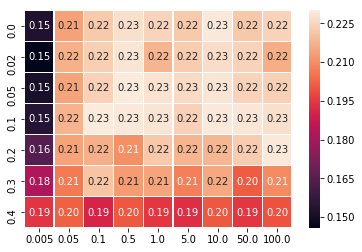

In [16]:
lasso_inv_p(betas,Cs, lfc_mb_filt,qval_mb_filt)

In [18]:
def lasso_min_p(lfc, qval, C):
    X=lfc[lfc_cols].values
    y=lfc['Functional_Category'].values
    #replace values lower than 0.05 with 0.05
    qval=qval[qval_cols].apply(lambda x: np.where(x<0.05, 0.05,x))
    qval=qval[qval_cols].values
    #print(X,y)
    accuracy=[]
    X=X*(1-qval)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train=SMOTE().fit_resample(X_train, y_train)
        clf=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
        clf.fit(X_train,y_train)
        y_hat=clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_hat))
    print (accuracy)
    #return accuracy

In [19]:
lasso_min_p(lfc_mb_filt,qval_mb_filt, C=10)

[0.24746450304259635, 0.1985743380855397, 0.19387755102040816]


In [59]:
def lasso_confusion(lfc,C, figsize=(7,7)):
    X=lfc[lfc_cols].values
    y=lfc['Functional_Category'].values
    n_classes=lfc['Functional_Category'].nunique()
    #print(X,y)
    accuracy=[]
    confusion=np.zeros((n_classes, n_classes))
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train=SMOTE().fit_resample(X_train, y_train)
        clf=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
        clf.fit(X_train,y_train)
        y_hat=clf.predict(X_test)
        confusion+=confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))
    confusion=confusion/3
    confusion=normalize(confusion, axis=1, norm='l1')
    print (accuracy)
    confusion=pd.DataFrame(confusion, columns=clf.classes_, index=clf.classes_)
    plt.figure(figsize=figsize)
    sns.heatmap(confusion, annot=True, linewidths=.1, fmt='1.2f', square=True)
    return None
            
            
    

[0.21703853955375255, 0.20061099796334012, 0.22346938775510203]


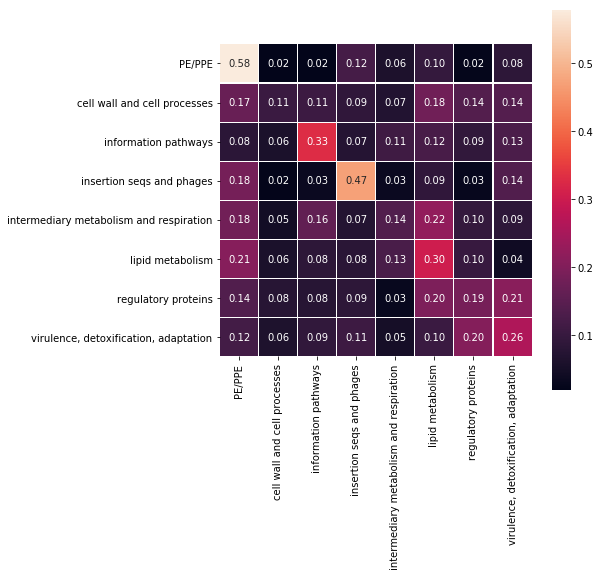

In [66]:
lasso_confusion(lfc_mb_filt, C=10)

In [23]:
def lasso_coefs(lfc, C):
    X=lfc[lfc_cols].values
    y=lfc['Functional_Category'].values
    #print(X,y)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    X_train, y_train=SMOTE().fit_resample(X, y)
    clf=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
    clf.fit(X_train,y_train)
    coefs=clf.coef_
    coefs=np.transpose(coefs)
    coefs=pd.DataFrame(coefs, columns=clf.classes_, index=lfc_cols)
    #print(clf.coef_)
    return coefs
            
            
    

In [24]:
lasso_coefs(lfc_mb_filt, C=10).to_csv(pathlib.Path.cwd().joinpath('results','LR_mb_coefs.csv'))

In [25]:
def lfc_add_features(lfc):
    lfc = lfc.copy(deep=True)
    col_indexes=range(len(lfc_cols))
    for n1 in col_indexes:
        for n2 in col_indexes[n1+1:]:
            new_name=lfc_cols[n1]+'_minus_'+lfc_cols[n2]
            #print (new_name)
            lfc[new_name]=lfc[lfc_cols[n1]]-lfc[lfc_cols[n2]]
    return lfc

In [26]:
lfc_mb_expanded=lfc_add_features(lfc_mb_filt)

In [27]:
def lasso_vanilla(lfc, Cs):
    X=lfc[lfc_cols].values
    y=lfc['Functional_Category'].values
    #print(X,y)
    accuracy={}
    for C in Cs:        
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        accuracy_per_fold=[]
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train, y_train=SMOTE().fit_resample(X_train, y_train)
            clf=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
            clf.fit(X_train,y_train)
            y_hat=clf.predict(X_test)
            accuracy_per_fold.append(accuracy_score(y_test, y_hat))
        accuracy[C]=sum(accuracy_per_fold)/len(accuracy_per_fold)
    print (accuracy)
    #return accuracy
    

In [28]:
lasso_vanilla(lfc_mb_expanded, Cs=[0.005,0.05,0.1,1,10,50,100,500])

{0.005: 0.15126632013856178, 0.05: 0.21642113689355227, 0.1: 0.222839546662123, 1: 0.22692528517833147, 10: 0.2180928990740899, 50: 0.22218893597188857, 100: 0.21437830135917, 500: 0.22255669737520686}


In [ ]:
## With COG Categories

In [30]:
cogs=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('dash','all_cogs.csv'))

In [38]:
cogs[cogs['X.Orf'].duplicated()].shape

(158, 2)

In [39]:
lfc_cog=pd.merge(lfc,cogs, left_on='Rv_ID', right_on='X.Orf')

In [40]:
print(lfc.shape, lfc_cog.shape)

(3990, 57) (4145, 59)


In [44]:
sum(lfc_cog['COG'].isna())

0

In [46]:
lfc_cog=lfc_cog.drop(columns='X.Orf')
lfc_cog=lfc_cog.rename(columns={'COG': 'Functional_Category'})

In [48]:
lfc_cog['Functional_Category'].value_counts()

S    1372
R     521
C     222
L     218
K     201
Q     197
I     189
E     182
J     160
H     141
P     135
G     120
M     114
T      99
O      88
F      65
V      49
D      44
U      27
A       1
Name: Functional_Category, dtype: int64

In [50]:
lfc_cog_filt=lfc_cog[~lfc_cog['Functional_Category'].isin(['A', 'U', 'D', 'V', 'S'])]

In [52]:
lasso_vanilla(lfc_cog_filt, Cs=[0.05,0.1, 0.2, 0.5, 1.0, 50, 100])

{0.05: 0.12823258428397633, 0.1: 0.14292969584635454, 0.2: 0.13761423301866235, 0.5: 0.13836763001964691, 1.0: 0.1474293601947281, 50: 0.1478060080290031, 100: 0.13576948087104204}


[0.13416009019165728, 0.1310734463276836, 0.14204545454545456]


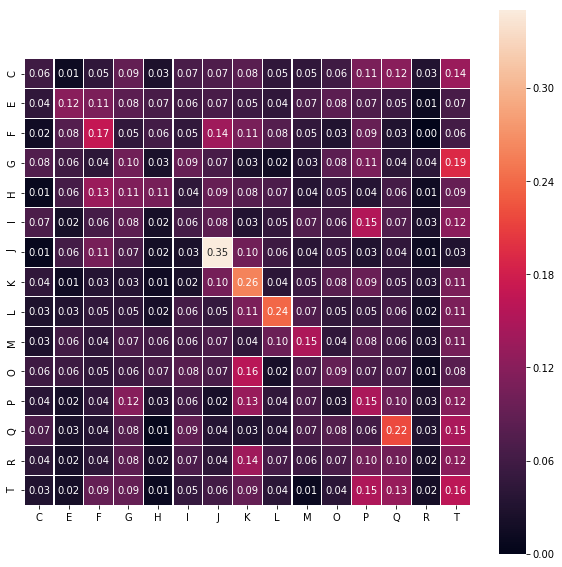

In [61]:
lasso_confusion(lfc_cog_filt, C=0.1, figsize=(10,10))

In [65]:
lfc_cog_filt.to_csv(pathlib.Path.cwd().joinpath('cleaned_data','lfc_cog_filt.csv'), index=False)